In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from matplotlib import pyplot as plt
# !pip install shap
# !pip install lime
import shap
import lime
from lime import lime_tabular

In [ ]:
# Load Train Dataset
root_dir = "./archive"
Train=pd.read_csv(root_dir + "/Train.csv")
Train_Beneficiarydata=pd.read_csv(root_dir + "/Train_Beneficiarydata.csv")
Train_Inpatientdata=pd.read_csv(root_dir + "/Train_Inpatientdata.csv")
Train_Outpatientdata=pd.read_csv(root_dir + "/Train_Outpatientdata.csv")

# Load Test Dataset

Test=pd.read_csv(root_dir + "/Test.csv")
Test_Beneficiarydata=pd.read_csv(root_dir + "/Test_Beneficiarydata.csv")
Test_Inpatientdata=pd.read_csv(root_dir + "/Test_Inpatientdata.csv")
Test_Outpatientdata=pd.read_csv(root_dir + "/Test_Outpatientdata.csv")

In [ ]:
class PreProcess():
  def __init__(self):
    self.last_dod = None
    self.onehotencoder = OneHotEncoder()

  def __preprocess_bene(self, df, stage):
    '''
    df: dataframe

    stage : 'train' or 'test'
    '''
    df['DOD'] = pd.to_datetime(df['DOD'],errors='ignore')
    df['DOB'] = pd.to_datetime(df['DOB'] )
    df['Age'] = round(((df['DOD'] - df['DOB']).dt.days)/365)

    if stage == "train":
      self.last_dod = df['DOD'].max()
      with open("last_dod", "wb") as f:
        pickle.dump({"last_dod": self.last_dod},f)
    
    df.Age.fillna(round(((self.last_dod - df['DOB']).dt.days)/365),
                                      inplace=True)


    df['Alive'] =["Yes" if pd.isna(i) else "No" for i in df['DOD']]

    df = df.replace({'Gender': 2,'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                           'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2, 
                           'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2, 
                           'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2 }
                           , 0)
    
    df = df.replace({'RenalDiseaseIndicator': 'Y'}, 1)
    
    return df

  def __preprocess_inpatient(self, df, stage):
    df['AdmissionDt'] = pd.to_datetime(df['AdmissionDt'])
    df['DischargeDt'] = pd.to_datetime(df['DischargeDt'])
    df['AdmitForDays'] = ((df['DischargeDt'] - df['AdmissionDt']).dt.days.abs())+1

    return df
  
  def merge_and_preprocess(self, class_df, Beneficiarydata, Inpatientdata, Outpatientdata, stage):
    def N_unique_values(df):
      return np.array([len(set([i for i in x[~pd.isnull(x)]])) for x in df.values])

    Beneficiarydata = self.__preprocess_bene(Beneficiarydata, stage=stage)
    Inpatientdata = self.__preprocess_inpatient(Inpatientdata, stage=stage)
    
    patient_merge_id = [i for i in Outpatientdata.columns if i in Inpatientdata.columns]

    # Merge Inpatient, Outpatient and beneficiary dataframe into a single patient dataset
    Patient_data = pd.merge(Inpatientdata, Outpatientdata,
                        left_on = patient_merge_id,
                        right_on = patient_merge_id,
                        how = 'outer').merge(Beneficiarydata,left_on='BeneID',right_on='BeneID',how='inner')
    
    Patient_data[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']] = np.where(Patient_data[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']].isnull(), 0, 1)
    Patient_data['N_Types_Physicians'] = Patient_data['AttendingPhysician'] +  Patient_data['OperatingPhysician'] + Patient_data['OtherPhysician']

    Patient_data['IsDiagnosisCode'] = np.where(Patient_data.DiagnosisGroupCode.isnull(), 0, 1)
    Patient_data = Patient_data.drop(['DiagnosisGroupCode'], axis = 1)

    Patient_data['DeductibleAmtPaid'].fillna(0,inplace=True)
    Patient_data['IsDeductibleAmtPaid']=np.where(Patient_data['DeductibleAmtPaid']==0,0,1)

    Patient_data['AdmitForDays'].fillna(0,inplace=True)

    # handle ClmProcedureCodes variables 

    ClmProcedure_vars = ['ClmProcedureCode_{}'.format(x) for x in range(1,7)]

    # count the number of procedureCode for each claim and store these value in a new variable
    Patient_data['N_Procedure'] = N_unique_values(Patient_data[ClmProcedure_vars])

    ### Handling of 'ClmDiagnosisCode'
    
    ClmDiagnosisCode_vars = ['ClmAdmitDiagnosisCode'] + ['ClmDiagnosisCode_{}'.format(x) for x in range(1, 11)]
    
    # We count the number of claims

    Patient_data['N_UniqueDiagnosis_Claims'] = N_unique_values(Patient_data[ClmDiagnosisCode_vars])
    
    if stage == 'train':
      x = self.onehotencoder.fit_transform(Patient_data.Race.values.reshape(-1, 1)).toarray()
      with open("encoder", "wb") as f: 
        pickle.dump(self.onehotencoder, f)

      df_OneHot = pd.DataFrame(x, columns = ["Race_"+str(int(i)) for i in range(1,5)]) 
      
      Patient_data = pd.concat([Patient_data, df_OneHot], axis=1)
      Patient_data.drop(['Race'], axis=1,inplace=True)

    if stage == 'test':
      x = self.onehotencoder.transform(Patient_data.Race.values.reshape(-1, 1)).toarray()

      df_OneHot = pd.DataFrame(x, columns = ["Race_"+str(int(i)) for i in range(1,5)]) 
      
      Patient_data = pd.concat([Patient_data, df_OneHot], axis=1)
      Patient_data.drop(['Race'], axis=1,inplace=True)

    Count = Patient_data[['BeneID', 'ClaimID']].groupby(Patient_data['Provider']).nunique().reset_index()
    Count.rename(columns={'BeneID':'BeneID_count','ClaimID':'ClaimID_count'},inplace=True)

    Data_Sum = Patient_data.groupby(['Provider'], as_index = False)[['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'RenalDiseaseIndicator', 
                                                     'AttendingPhysician','OperatingPhysician','OtherPhysician','AdmitForDays',
                                                    'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure','ChronicCond_Cancer', 
                                                    'ChronicCond_KidneyDisease', 'ChronicCond_ObstrPulmonary',
                                                   'ChronicCond_Depression','ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',   
                                                    'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
                                                    'ChronicCond_stroke', 'IPAnnualReimbursementAmt','IPAnnualDeductibleAmt',
                                                    'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Alive',
                                                    'N_Types_Physicians','IsDiagnosisCode', 'N_Procedure', 'N_UniqueDiagnosis_Claims']].sum()
    Data_Mean=round(Patient_data.groupby(['Provider'], as_index = False)[['NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
                                                                            'Age']].mean())
    
    df=pd.merge(Count,Data_Sum,on='Provider',how='left').\
                merge(Data_Mean,on='Provider',how='left').\
                merge(class_df,on='Provider',how='right')
    
    return df

In [ ]:
p = PreProcess()
data = p.merge_and_preprocess(Train, Train_Beneficiarydata, Train_Inpatientdata, Train_Outpatientdata, stage="train")

In [ ]:
data.shape

(5410, 32)

In [ ]:
Y = data['PotentialFraud']

X = data.drop(['PotentialFraud'], axis = 1)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

In [ ]:
x_train.head()

,Provider,BeneID_count,ClaimID_count,InscClaimAmtReimbursed,DeductibleAmtPaid,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmitForDays,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_Cancer,ChronicCond_KidneyDisease,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,N_Types_Physicians,IsDiagnosisCode,N_Procedure,N_UniqueDiagnosis_Claims,NoOfMonths_PartACov,NoOfMonths_PartBCov,Age
4326,PRV56407,39,40,39500,5440.0,40,7,13,36.0,16,22,4,14,7,18,27,27,14,11,5,106160,12816,62410,16310,60,5,6,139,11.0,12.0,70.0
4948,PRV57202,85,165,40810,560.0,165,31,75,0.0,73,111,24,83,65,96,123,139,47,61,10,1368510,105732,497530,156380,271,0,0,437,12.0,12.0,76.0
4409,PRV56518,2,2,900,0.0,2,1,1,0.0,2,2,0,2,0,2,2,2,1,1,0,4000,1068,2360,580,4,0,0,6,12.0,12.0,82.0
3444,PRV55320,27,34,6400,0.0,34,3,12,0.0,12,14,4,13,5,8,23,28,7,12,2,85650,14484,43160,11760,49,0,0,91,12.0,12.0,75.0
236,PRV51301,63,112,136910,6718.0,111,21,40,64.0,36,56,18,47,38,52,86,83,41,34,4,964070,70196,243640,74130,172,6,6,358,12.0,12.0,71.0


In [ ]:
y_train

Provider
PRV56407     No
PRV57202     No
PRV56518     No
PRV55320     No
PRV51301     No
           ... 
PRV51733     No
PRV55027    Yes
PRV57634     No
PRV51325     No
PRV54038     No
Name: PotentialFraud, Length: 4328, dtype: object

# XGBoost

In [ ]:
clf = XGBClassifier(random_state=42, class_weight='balanced')

params ={
    "max_depth": [1, 3, 10], 
    "learning_rate": [0.1, 0.01, 0.001], 
    "n_estimators": [1200, 1400, 2000,2400]
}

gs = GridSearchCV(clf, params, cv=3, n_jobs=-1, scoring='f1', return_train_score=True, verbose=2)
gs.fit(x_train.drop(['Provider'], axis = 1), np.where(y_train=='No', 0, 1))

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(class_weight='balanced', random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [1, 3, 10],
                         'n_estimators': [1200, 1400, 2000, 2400]},
             return_train_score=True, scoring='f1', verbose=2)

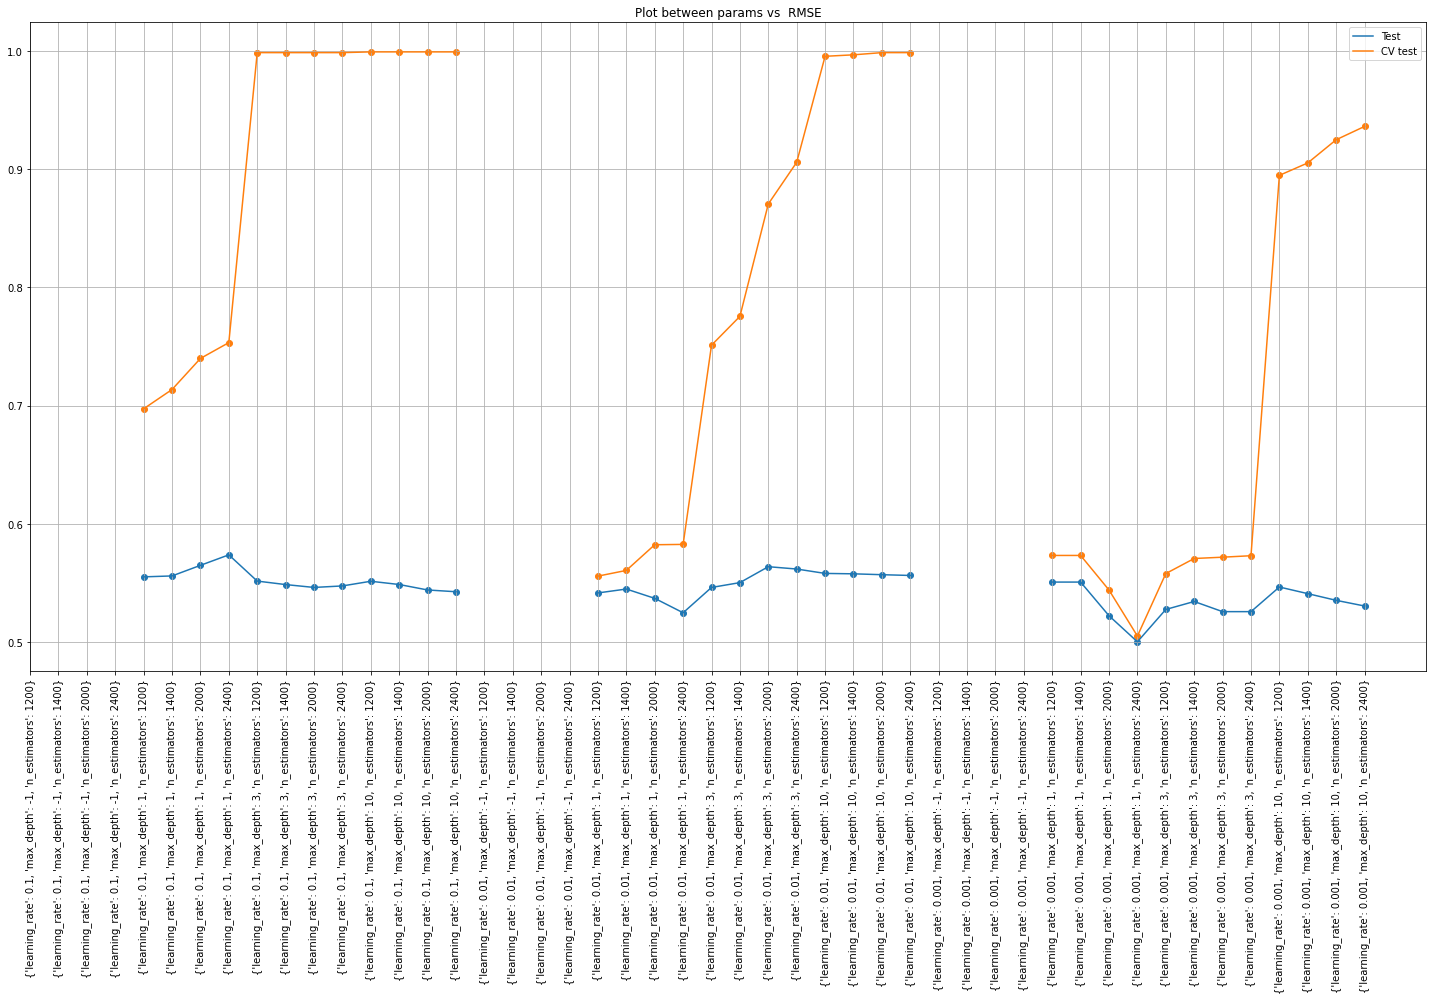

In [ ]:
plt.figure(figsize=(20,14))
plt.title("Plot between params vs  RMSE")
plt.plot(abs(gs.cv_results_['mean_test_score']), label='Test')
plt.plot(abs(gs.cv_results_['mean_train_score']), label='CV test')

plt.scatter(np.arange(0,len(gs.cv_results_['mean_test_score'])),abs(gs.cv_results_['mean_test_score']))
plt.scatter(np.arange(0,len(gs.cv_results_['mean_train_score'])),abs(gs.cv_results_['mean_train_score']))

plt.xticks((np.arange(0,len(gs.cv_results_['mean_test_score']))), gs.cv_results_['params'], rotation='vertical')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
clf = XGBClassifier(random_state=42, class_weight='balanced', n_estimators=1200, max_depth=1, learning_rate=0.01)

clf.fit(x_train.drop(['Provider'], axis = 1), y_train)

pred = clf.predict(x_test.drop(['Provider'], axis = 1))

In [ ]:
accuracy_score(y_test, pred)

0.9417744916820703

In [ ]:
confusion_matrix(y_test, pred)

array([[975,   6],
       [ 57,  44]])

In [ ]:
f1_score(np.where(y_test=='No', 0, 1), np.where(pred=='No', 0, 1))

0.5827814569536424

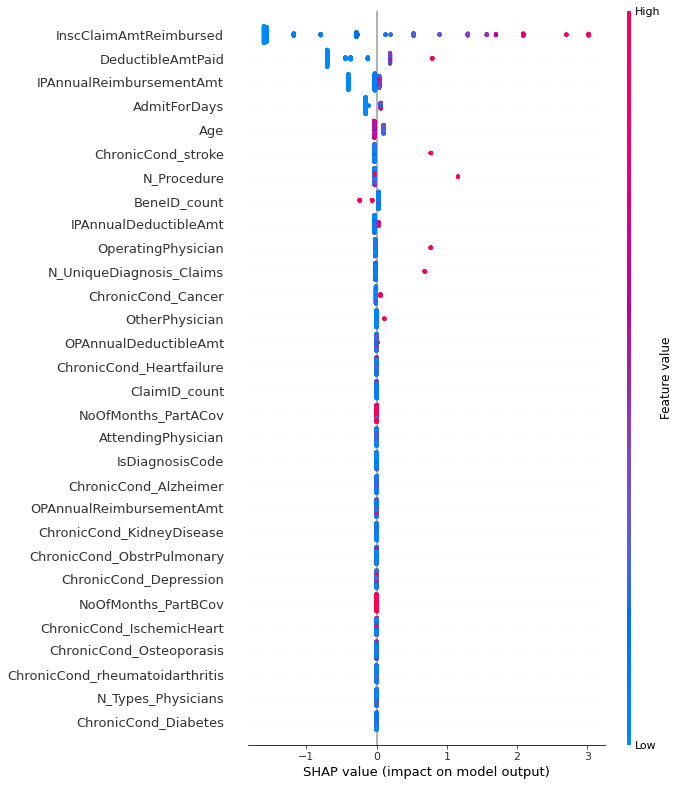

In [ ]:
explainer = shap.Explainer(clf)
shap_values = explainer(x_test.drop(['Provider'], axis = 1))

shap.plots.beeswarm(shap_values, max_display=32)

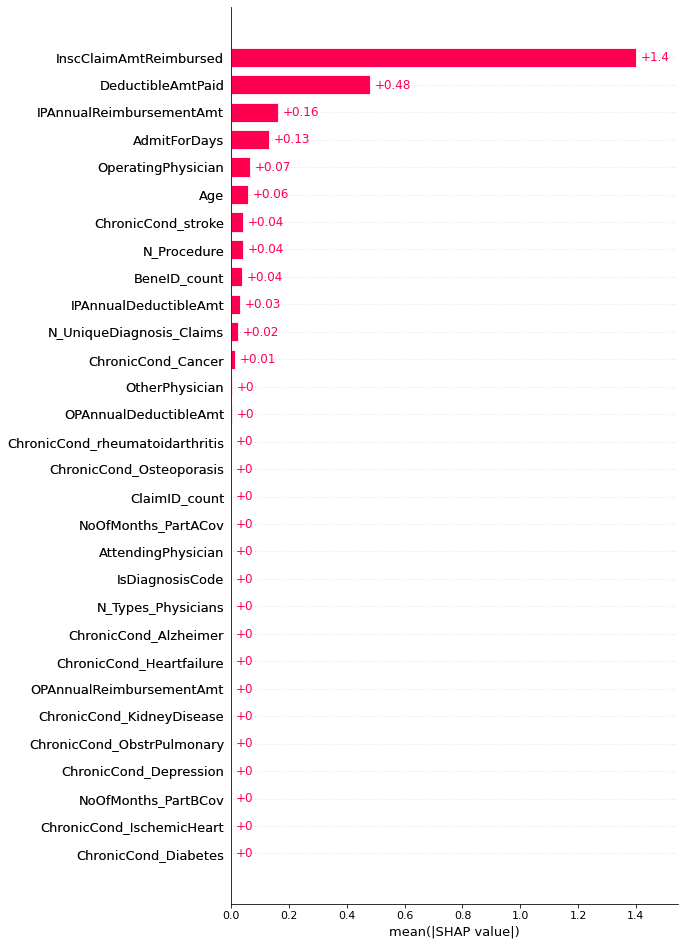

In [ ]:
shap.plots.bar(shap_values, max_display=32)

<h1><B>Observation : </B></h1>

1. We could use some kind of upsampling techniques to increase the posiive number of classes.

2. From SHAP analysis we can see there are lot of features which are not useful. 